In [13]:
#D'abord vérifier si on a du Lenet

In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, preprocessing 
from keras.applications.imagenet_utils import preprocess_input
from sklearn import metrics
%matplotlib inline


Using TensorFlow backend.


In [2]:
def build_model(width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [3]:
#Essayons de faire lenet avec tf voir ci-dessous . Il y a aussi une commande pour voir le résumer peut être .resume
def build_model(width, height, depth, classes,drop_out_rate):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(30, (5, 5), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
        
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(16, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),

        
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(128),
		Activation("relu"),
		BatchNormalization(),
		Dropout(drop_out_rate),
        
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [4]:

df=pd.read_csv("/home/marcpozzo/Desktop/c3po/Images_aquises/generateur.csv")
df=df[(df["class"]=='corneille') | (df["class"]=='pigeon') | (df["class"]=='faisan')   ]
df.drop('labels',inplace=True,axis=1)
df.head()

,class,img_paths
2,corneille,Rec_images/DSCF0180_corneille_2.JPG
3,corneille,Rec_images/DSCF0180_corneille_3.JPG
4,pigeon,Rec_images/DSCF0258_pigeon_4.JPG
8,pigeon,Rec_images/DSCF0335_pigeon_8.JPG
10,pigeon,Rec_images/DSCF0341_pigeon_10.JPG


In [5]:
#Paramètres

#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.2
epochs=200
batch_size = 600
zoom_range = 1.25
horizontal_flip = True
Minimum_Number_Class=100
dropout_rate=0.3
#steps_per_epoch=len(data_train)//batch_size
steps_per_epoch=1
#validation_steps=len(data_test)//batch_size
validation_steps=1


In [6]:

base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Images_aquises/generateur_bigger.csv'

df=pd.read_csv(generateur_path)
df.drop('labels',inplace=True,axis=1)

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["class"].unique()


All_Unique=df["class"].unique()
Utilisable=[]
for i in df["class"].unique():
    if df["class"][df["class"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["class"]!=i]
df=df[df["class"]!="oiseau"]  
df["class"].unique()


for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    

class: 13
img_paths: 6220


In [7]:
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input
        # data augmentation
        #rotation_range = 10,
        #zoom_range = zoom_range,
        #horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]


Found 4772 validated image filenames belonging to 6 classes.
Found 1194 validated image filenames belonging to 6 classes.


In [ ]:
#First test the influence of number of epochs on the other recall

In [13]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92       734
           1       0.59      0.94      0.73        17
           2       0.88      0.84      0.86       225
           3       0.45      0.58      0.50        52
           4       0.34      0.75      0.47        16
           5       0.75      0.83      0.79       150

    accuracy                           0.86      1194
   macro avg       0.66      0.81      0.71      1194
weighted avg       0.88      0.86      0.87      1194



In [18]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test))

plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])

KeyboardInterrupt: 

In [9]:
import cv2
x_train_hsv=[ cv2.cvtColor(x_train[i], cv2.COLOR_RGB2HSV) for i in range(len(y_train))    ]
x_train_hsv=np.array((x_train_hsv))
x_train_hsv.shape


x_test_hsv=[ cv2.cvtColor(x_test[i], cv2.COLOR_RGB2HSV) for i in range(len(y_test))    ]
x_test_hsv=np.array((x_test_hsv))



              precision    recall  f1-score   support

           0       0.97      0.93      0.95       716
           1       0.56      0.56      0.56        27
           2       0.91      0.91      0.91       215
           3       0.72      0.92      0.81        52
           4       0.77      0.84      0.81        32
           5       0.81      0.89      0.85       152

    accuracy                           0.91      1194
   macro avg       0.79      0.84      0.81      1194
weighted avg       0.92      0.91      0.91      1194



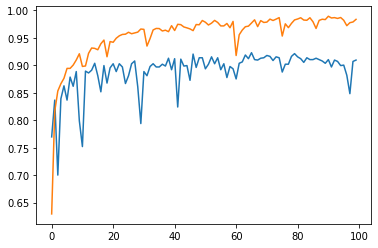

In [19]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train_hsv,y_train,epochs=100,validation_data=(x_test_hsv,y_test),verbose=0)
y_predict=model.predict(x_test_hsv).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test))

plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])

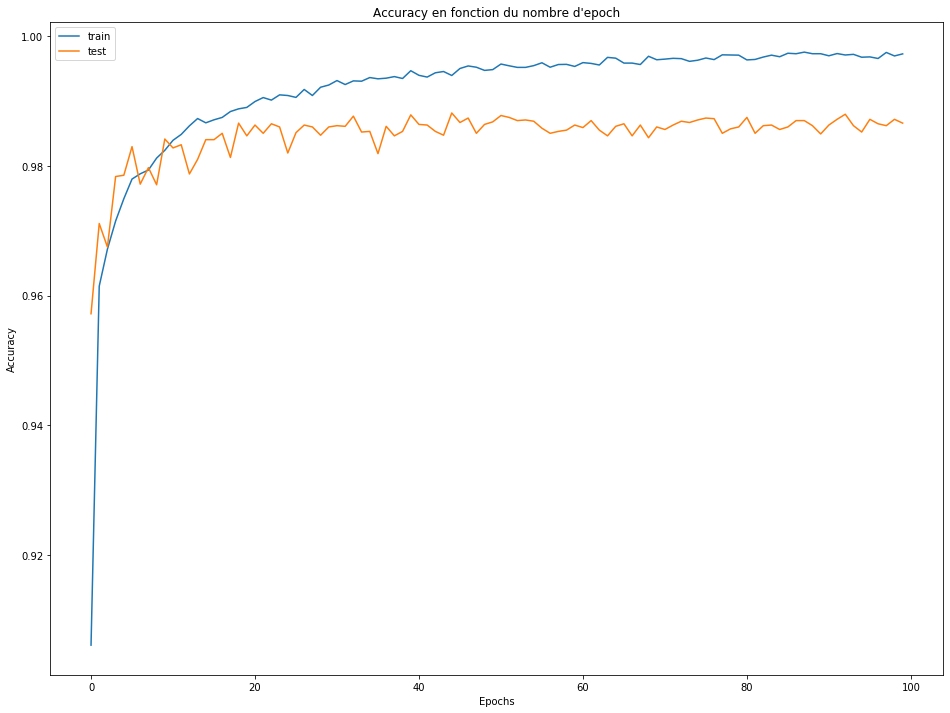

In [14]:
plt.figure(figsize=(16,12))

plt.plot(history.history['acc'],label="train");
plt.plot(history.history['val_acc'],label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();

In [14]:
#Export model
model.save("tf_fp_100ep")

### Import model
#new_model = tf.keras.models.load_model('model_test')

In [14]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       749
           1       0.74      0.83      0.78        24
           2       0.86      0.92      0.88       201
           3       0.48      0.86      0.62        37
           4       0.37      0.54      0.44        24
           5       0.87      0.91      0.89       159

    accuracy                           0.89      1194
   macro avg       0.72      0.83      0.76      1194
weighted avg       0.91      0.89      0.90      1194



In [14]:
#Nouveau
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)

In [18]:
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.98538   0.95467   0.96978       706
           1    0.85185   0.92000   0.88462        25
           2    0.91628   0.93365   0.92488       211
           3    0.82090   0.88710   0.85271        62
           4    0.71429   0.78125   0.74627        32
           5    0.90361   0.94937   0.92593       158

    accuracy                        0.94137      1194
   macro avg    0.86538   0.90434   0.88403      1194
weighted avg    0.94375   0.94137   0.94219      1194



In [15]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       707
           1       0.70      0.90      0.79        21
           2       0.89      0.85      0.87       227
           3       0.60      0.74      0.66        54
           4       0.46      0.59      0.52        27
           5       0.87      0.92      0.90       158

    accuracy                           0.89      1194
   macro avg       0.75      0.82      0.78      1194
weighted avg       0.90      0.89      0.90      1194



In [17]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=1000,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       732
           1       0.59      0.94      0.73        17
           2       0.88      0.87      0.88       219
           3       0.57      0.81      0.67        47
           4       0.40      0.58      0.47        24
           5       0.86      0.92      0.88       155

    accuracy                           0.89      1194
   macro avg       0.71      0.84      0.76      1194
weighted avg       0.90      0.89      0.89      1194



In [ ]:
#See the influence of drop_out rate on other _recall

In [24]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.96053   0.90997   0.93457       722
           1    0.77778   0.80769   0.79245        26
           2    0.86977   0.89048   0.88000       210
           3    0.56716   0.74510   0.64407        51
           4    0.57143   0.55556   0.56338        36
           5    0.81325   0.90604   0.85714       149

    accuracy                        0.88610      1194
   macro avg    0.75999   0.80247   0.77860      1194
weighted avg    0.89367   0.88610   0.88861      1194



In [25]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.1)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.96491   0.89918   0.93089       734
           1    0.70370   0.86364   0.77551        22
           2    0.89302   0.83843   0.86486       229
           3    0.49254   0.76744   0.60000        43
           4    0.45714   0.59259   0.51613        27
           5    0.80120   0.95683   0.87213       139

    accuracy                        0.88191      1194
   macro avg    0.71875   0.81969   0.75992      1194
weighted avg    0.89876   0.88191   0.88723      1194



In [26]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.2)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.96930   0.91575   0.94176       724
           1    0.70370   0.90476   0.79167        21
           2    0.89767   0.86161   0.87927       224
           3    0.55224   0.80435   0.65487        46
           4    0.60000   0.61765   0.60870        34
           5    0.81928   0.93793   0.87460       145

    accuracy                        0.89531      1194
   macro avg    0.75703   0.84034   0.79181      1194
weighted avg    0.90639   0.89531   0.89870      1194



In [27]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.4)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.97953   0.90541   0.94101       740
           1    0.70370   0.90476   0.79167        21
           2    0.88837   0.90094   0.89461       212
           3    0.41791   0.77778   0.54369        36
           4    0.54286   0.70370   0.61290        27
           5    0.87952   0.92405   0.90123       158

    accuracy                        0.89866      1194
   macro avg    0.73532   0.85277   0.78085      1194
weighted avg    0.91845   0.89866   0.90548      1194



In [28]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.95906   0.92786   0.94321       707
           1    0.70370   0.90476   0.79167        21
           2    0.89302   0.84581   0.86878       227
           3    0.59701   0.74074   0.66116        54
           4    0.45714   0.59259   0.51613        27
           5    0.87349   0.91772   0.89506       158

    accuracy                        0.89447      1194
   macro avg    0.74724   0.82158   0.77933      1194
weighted avg    0.90297   0.89447   0.89761      1194



In [29]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.5)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.97661   0.91758   0.94618       728
           1    0.70370   0.90476   0.79167        21
           2    0.88372   0.91346   0.89835       208
           3    0.52239   0.83333   0.64220        42
           4    0.68571   0.57143   0.62338        42
           5    0.89157   0.96732   0.92790       153

    accuracy                        0.90787      1194
   macro avg    0.77728   0.85131   0.80494      1194
weighted avg    0.91852   0.90787   0.91074      1194



In [30]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.5)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.97661   0.91758   0.94618       728
           1    0.70370   0.90476   0.79167        21
           2    0.88372   0.91346   0.89835       208
           3    0.52239   0.83333   0.64220        42
           4    0.68571   0.57143   0.62338        42
           5    0.89157   0.96732   0.92790       153

    accuracy                        0.90787      1194
   macro avg    0.77728   0.85131   0.80494      1194
weighted avg    0.91852   0.90787   0.91074      1194



In [31]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.6)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.96199   0.93333   0.94744       705
           1    0.85185   0.95833   0.90196        24
           2    0.91163   0.85965   0.88488       228
           3    0.61194   0.82000   0.70085        50
           4    0.48571   0.54839   0.51515        31
           5    0.86145   0.91667   0.88820       156

    accuracy                        0.90285      1194
   macro avg    0.78076   0.83939   0.80641      1194
weighted avg    0.91000   0.90285   0.90529      1194



In [32]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.7)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.98684   0.91588   0.95004       737
           1    0.62963   0.94444   0.75556        18
           2    0.91628   0.88739   0.90160       222
           3    0.53731   0.85714   0.66055        42
           4    0.51429   0.78261   0.62069        23
           5    0.86145   0.94079   0.89937       152

    accuracy                        0.90955      1194
   macro avg    0.74097   0.88804   0.79797      1194
weighted avg    0.92746   0.90955   0.91512      1194



In [33]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.8)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.97222   0.92361   0.94729       720
           1    0.74074   0.95238   0.83333        21
           2    0.92093   0.87225   0.89593       227
           3    0.64179   0.86000   0.73504        50
           4    0.57143   0.74074   0.64516        27
           5    0.83735   0.93289   0.88254       149

    accuracy                        0.90871      1194
   macro avg    0.78074   0.88031   0.82322      1194
weighted avg    0.91867   0.90871   0.91172      1194



In [34]:
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.9)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=500,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.96637   0.92707   0.94631       713
           1    0.77778   0.80769   0.79245        26
           2    0.94419   0.87879   0.91031       231
           3    0.67164   0.86538   0.75630        52
           4    0.45714   0.80000   0.58182        20
           5    0.84337   0.92105   0.88050       152

    accuracy                        0.90955      1194
   macro avg    0.77675   0.86666   0.81128      1194
weighted avg    0.92095   0.90955   0.91324      1194

